In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
from datetime import datetime

# Update the dateparse function for the format 'dd-mm-yy'
df = pd.read_csv('daily_wholesale_price_Wheat-upto_apr_2015.csv')
df = df.dropna() 


In [3]:
# Group by 'Date' and compute the average Price

df = df.groupby('Date')['Price'].mean().reset_index()
print(df.shape)
df.head()

(1553, 2)


,Date,Price
0,01-01-09,1172.857143
1,01-01-10,1689.750000
2,01-01-13,1832.666667
3,01-01-14,1954.774194
4,01-01-15,1826.428571


In [4]:
# Convert 'Date' column to datetime format (if it's not already)
df['Date'] = pd.to_datetime(df['Date'])

# Group by 'Date' and compute the average Price
df = df.groupby('Date')['Price'].mean().reset_index()

df.set_index('Date',inplace = True)
df

,Price
Date,
2009-01-01,1172.857143
2009-01-04,1265.000000
2009-01-05,1095.000000
2009-01-06,1268.750000
2009-01-07,1206.875000
...,...
2015-11-02,2020.054545
2015-11-03,2019.309091
2015-12-01,1923.750000


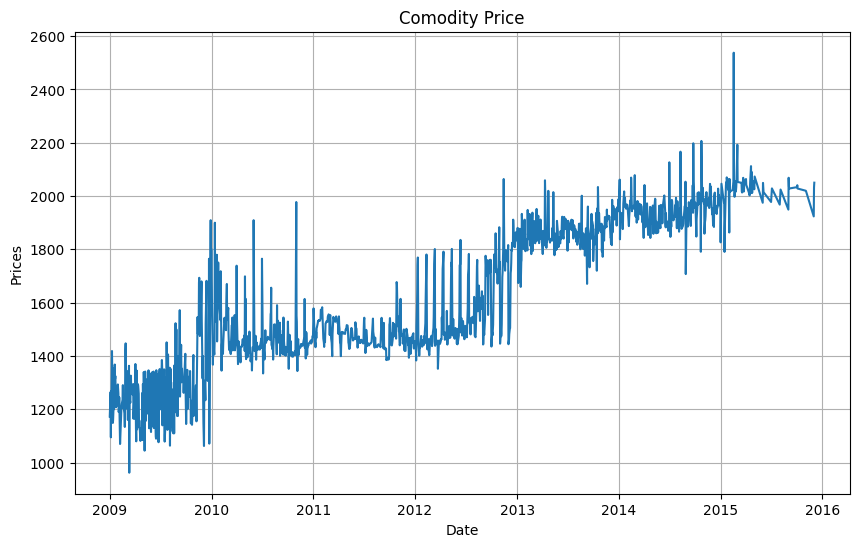

In [5]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Prices')
plt.plot(df['Price'])
plt.title('Comodity Price')
plt.show()

In [6]:
def check_stationarity(series):
    result = adfuller(series.dropna())  # Drop NA values if present
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The data is stationary")
    else:
        print("The data is not stationary")

In [7]:
temp = pd.Series(df['Price'], index=df.index, name='Prices')

check_stationarity(temp)

ADF Statistic: -0.5389520653425615
p-value: 0.8841885314497353
The data is not stationary


In [8]:
diff_data = temp.diff().dropna()
check_stationarity(diff_data)

ADF Statistic: -17.690855111344696
p-value: 3.5727772859604236e-30
The data is stationary


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16751.570, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=16433.361, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=16337.886, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=16275.799, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=16229.183, Time=0.53 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=16401.737, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=16230.042, Time=0.81 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=16230.181, Time=0.79 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=16341.634, Time=0.50 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=16374.354, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=16229.727, Time=1.68 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=16224.894, Time=0.98 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=16272.485, Time=0.55 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=16403.602, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0

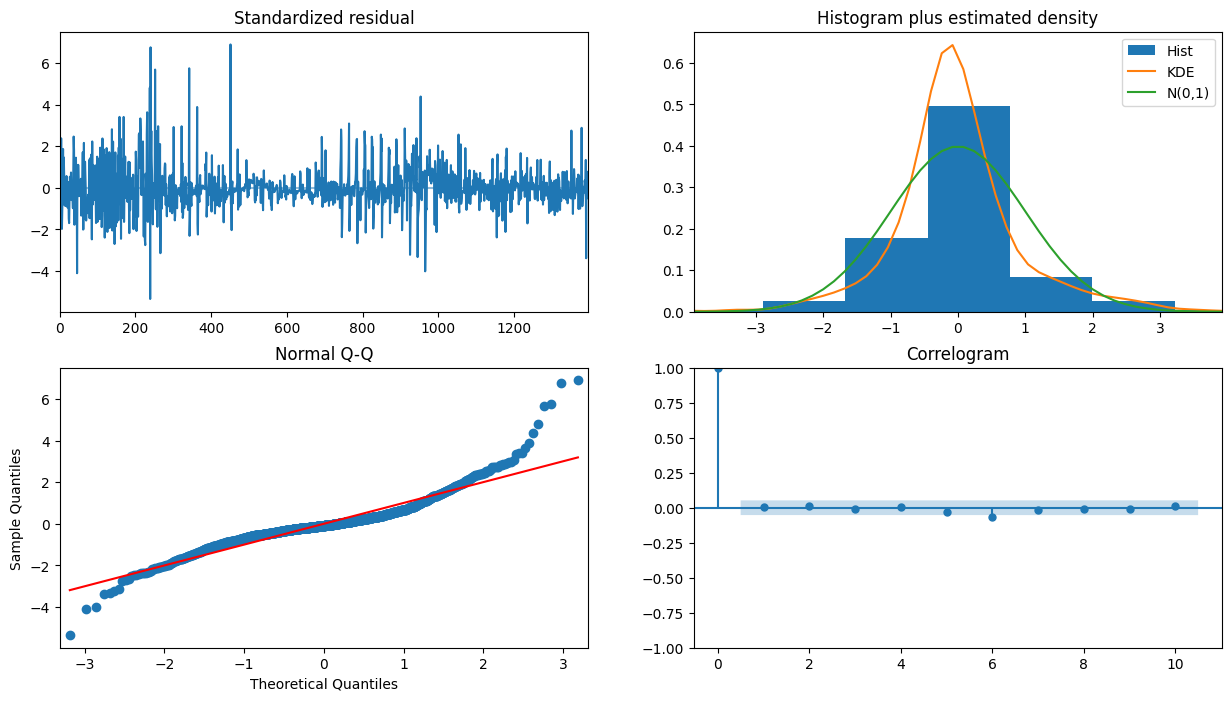

In [9]:
# Assuming 'Price' is the column you are interested in
df_log = df['Price']  # Use df['Price'] directly if it's already in log form

# Difference the data
diff_data = df_log.diff().dropna()

# Split the differenced data
train_size = int(len(diff_data) * 0.9)
train_data, test_data = diff_data[:train_size], diff_data[train_size:]

# Fit the auto_arima model with multiple processors
model_autoARIMA = auto_arima(
    train_data,
    start_p=0, 
    start_q=0,
    test='adf',       # use adftest to find optimal 'd'
    max_p=3, 
    max_q=3,         # maximum p and q
    m=1,              # frequency of series
    d=None,           # let model determine 'd'
    seasonal=False,   # No Seasonality
    start_P=0, 
    D=0, 
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True,
    n_jobs=-1         # Use all available processors
)

# Print summary
print(model_autoARIMA.summary())

# Plot diagnostics
model_autoARIMA.plot_diagnostics(figsize=(15, 8))
plt.show()


In [10]:
# Extract the best parameters
best_p = model_autoARIMA.order[0]
best_d = model_autoARIMA.order[1]
best_q = model_autoARIMA.order[2]

# Fit ARIMA model on the differenced data
model = ARIMA(train_data, order=(best_p, 0, best_q))  # No differencing needed here, 'd=0'
fitted = model.fit()

# Print summary
print(fitted.summary())

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1396
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -8107.447
Date:                Sun, 08 Sep 2024   AIC                          16224.894
Time:                        23:41:32   BIC                          16251.101
Sample:                             0   HQIC                         16234.692
                               - 1396                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5074      0.225      2.256      0.024       0.067       0.948
ar.L1          0.2861      0.018     16.304      0.000       0.252       0.320
ar.L2          0.1945      0.019     10.458      0.0

In [11]:
# Forecast future values
forecast_steps = len(test_data)
forecast = fitted.get_forecast(steps=forecast_steps)
forecast_df = forecast.summary_frame(alpha=0.05)

# Extract forecasted values, standard errors, and confidence intervals
fc_series = pd.Series(forecast_df['mean'].values, index=test_data.index)
lower_series = pd.Series(forecast_df['mean_ci_lower'].values, index=test_data.index)
upper_series = pd.Series(forecast_df['mean_ci_upper'].values, index=test_data.index)

# Reverse differencing to get back to original scale
last_observed_value = df_log.iloc[train_size]

# Create forecast index covering the entire test set
forecast_index = test_data.index

# Compute the forecasted series and its confidence intervals
forecast_series = pd.Series(last_observed_value + fc_series.cumsum(), index=forecast_index)
forecast_lower = pd.Series(last_observed_value + lower_series.cumsum(), index=forecast_index)
forecast_upper = pd.Series(last_observed_value + upper_series.cumsum(), index=forecast_index)


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


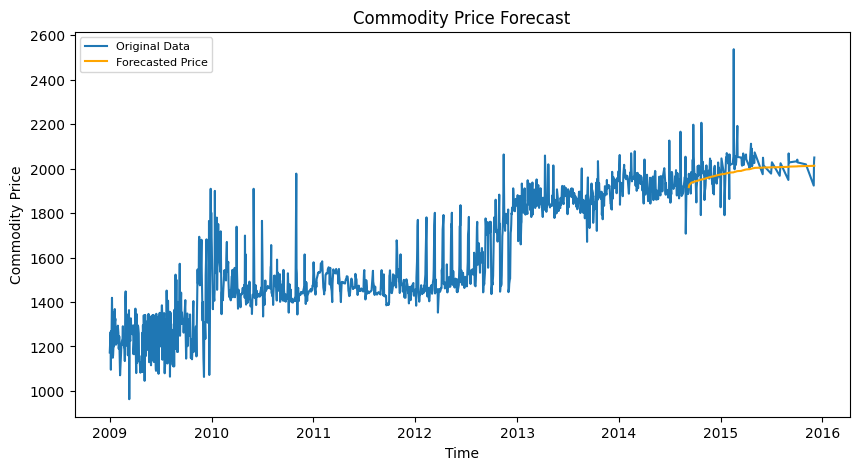

In [12]:

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(df_log, label='Original Data')
plt.plot(forecast_series, color='orange', label='Forecasted Price')
plt.title('Commodity Price Forecast')
plt.xlabel('Time')
plt.ylabel('Commodity Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [29]:
df_log[train_size:len(df_log)-1]

Date
2014-09-07    1903.782609
2014-09-09    1977.023810
2014-09-10    1959.613636
2014-09-12    1962.803922
2014-09-15    1924.666667
                 ...     
2015-10-04    2028.254237
2015-11-02    2020.054545
2015-11-03    2019.309091
2015-12-01    1923.750000
2015-12-02    2032.553571
Name: Price, Length: 156, dtype: float64

In [30]:
forecast_series

Date
2014-09-09    1916.667132
2014-09-10    1924.116082
2014-09-12    1929.017359
2014-09-15    1932.132292
2014-09-16    1934.240524
                 ...     
2015-11-02    2011.293247
2015-11-03    2011.800693
2015-12-01    2012.308139
2015-12-02    2012.815585
2015-12-03    2013.323031
Length: 156, dtype: float64

In [33]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

actual_series = df_log[train_size:]
forecast_series = forecast_series 

aligned_actual = actual_series.reindex(forecast_series.index)
aligned_forecast = forecast_series

aligned_actual = aligned_actual.dropna()
aligned_forecast = aligned_forecast.loc[aligned_actual.index]

if len(aligned_actual) != len(aligned_forecast):
    raise ValueError(f"Forecast and actual series have different lengths: {len(aligned_actual)} vs {len(aligned_forecast)}")

# Compute accuracy metrics
mae = mean_absolute_error(aligned_actual, aligned_forecast)
mse = mean_squared_error(aligned_actual, aligned_forecast)
mape = mean_absolute_percentage_error(aligned_actual, aligned_forecast)

# Print the results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")

Mean Absolute Error (MAE): 50.04
Mean Squared Error (MSE): 5854.07
Mean Absolute Percentage Error (MAPE): 2.46%
